<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [35]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// needed to generate the Table of contents 
// taken from github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

# Modeling
Importing modules and data from prevoius step


In [72]:
## Fit Models with Training Data Set
import pandas as pd
import numpy as np

#import joblib
import pickle

from timeit import default_timer as timer
from datetime import datetime, date
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fast')
import seaborn as sns

In [80]:
from timeit import default_timer as timer
from datetime import datetime, date
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [38]:
#Load data and scaler model

X_train_scaled = pd.read_csv("../data/X_train_scaled.csv").to_numpy()
y_train = pd.read_csv("../data/y_train.csv").to_numpy().ravel()
X_train_over_scaled = pd.read_csv("../data/X_train_over_scaled.csv").to_numpy()
y_train_over = pd.read_csv("../data/y_train_over.csv").to_numpy().ravel()
X_test_scaled = pd.read_csv("../data/X_test_scaled.csv").to_numpy()
y_test = pd.read_csv("../data/y_test.csv").to_numpy().ravel()
feature_list = pd.read_csv("../data/feature_list.csv")
feature_list = pd.Index(list(feature_list["0"]))

scaler = joblib.load("../data/scaler.pkl")

/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [39]:
train_df = pd.DataFrame(X_train_scaled, columns = feature_list)
train_df.head()

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.00000,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662
1,0.00277,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014
2,0.00554,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375
3,0.00831,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386
4,0.01108,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502


In [40]:
train_over_df = pd.DataFrame(X_train_over_scaled, columns = feature_list)
train_over_df.head()

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.637119,0.572289,0.485939,0.697839,0.438003,0.393939,0.174145,0.630952,0.439232,0.455882,0.136031,0.674875,0.583333,0.271318,0.428749
1,0.587258,0.605422,0.531502,0.697502,0.370370,0.393939,0.300592,0.589286,0.398721,0.382353,0.339147,0.354752,0.416667,0.434109,0.411627
2,0.570637,0.527108,0.273599,0.542370,0.470209,0.439394,0.143857,0.482143,0.471215,0.352941,0.171535,0.505194,0.416667,0.550388,0.474040
3,0.412742,0.734940,0.628515,0.539669,0.438003,0.318182,0.254375,0.571429,0.533049,0.338235,0.261430,0.430935,0.583333,0.472868,0.393262
4,0.324100,0.873494,0.586658,0.653275,0.325282,0.500000,0.135197,0.642857,0.296375,0.500000,0.140520,0.721431,0.500000,0.550388,0.258630


In [41]:
test_df = pd.DataFrame(X_test_scaled, columns = feature_list)
test_df.head()

,cycle_time,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.00000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834
1,0.00277,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827
2,0.00554,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348
3,0.00831,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110
4,0.01108,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377


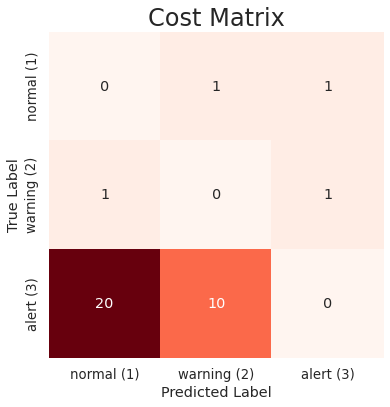

In [42]:
cost_matrix = [[0,1,1],[1,0,1],[20,10,0]]
categories = ['normal (1)','warning (2)','alert (3)']

fig = plt.figure(figsize=(6,6))
sns.set(font_scale=1.2)
ax = sns.heatmap(cost_matrix, annot=cost_matrix, fmt='', cmap='Reds', cbar=False, xticklabels=categories)
ax.set_yticklabels(categories, rotation=90, va="center")
sns.set(font_scale=1.4)
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
sns.set(font_scale=2)
ax.set_title('Cost Matrix')
plt.savefig("../figures/Cost_Matrix.png") 

## Fit Models with Training Data Set

Let's build some useful functions

In [43]:
def my_cost_function(y_test, y_pred):
    cost_matrix = [[0,1,1],[1,0,1],[20,10,0]]
    conf_matrix = confusion_matrix(y_test, y_pred)
    loss = -np.sum(conf_matrix*cost_matrix)
    return loss

my_score = make_scorer(my_cost_function, greater_is_better=False)

In [44]:
def try_model(model, X_train, y_train, X_test, y_test):
    """ Fits a model on the selected data with the default parameters 
    ex. usage 
        summary = try_model(KNeighborsClassifier(),X_train, y_train)"""
    # statements
    print('Trying Model :'+ str(model))
    start = timer()
    model.fit(X_train, y_train)
    middle = timer()
    test_score = model.score(X_test, y_test)
    #cv_score = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    end = timer()
    train_score = model.score(X_train, y_train) 
    
    
    #my_test_score = cross_val_score(model, X_test, y_test, cv=5, scoring=my_score)
    #print("|  Mean Cost: %0.2f (+/- %0.2f)" % (my_test_score.mean(), my_test_score.std() * 2))
    
    # calculate confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cost = my_cost_function(y_test, y_pred)
    
    print('|  Train Score: ' + str(round(train_score,3)))
    print('|  Test Score: ' + str(round(test_score,3)))
    
    train_elapsed = round(middle - start,3)
    test_elapsed = round(end - middle,3)

    summary = {'model_name': str(model),
               'training time [s]': train_elapsed,
               'test time [s]': test_elapsed,
               'test accuracy': test_score,
               'cost':cost,
               'train accuracy': train_score,
              'confusion matrix': cm,
              'trained_model':model}
    #print(summary)
    
    return summary

In [68]:
def plot_multiclass_confusion_matrix(y_test, y_pred, categories):
    """Plots the confusion matrix given the data and the lables."""
    
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    stats_text = "\n\nAccuracy={:0.2f}%".format(100*np.trace(cm) / float(np.sum(cm)))
    
    box_labels = [f"{v2}{v3}".strip() for v2, v3 in zip(group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

    fig = plt.figure(figsize=(6,6))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=box_labels, fmt='', cmap='Reds', xticklabels=categories, yticklabels=categories)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(stats_text)
    
    return fig, ax
 

def plot_multiclass_confusion_matrix_from_matrix(cm, categories):
    """Plots the confusion matrix given the data and the lables."""
    
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    stats_text = "\n\nAccuracy={:0.2f}%".format(100*np.trace(cm) / float(np.sum(cm)))
    
    box_labels = [f"{v2}{v3}".strip() for v2, v3 in zip(group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

    fig = plt.figure(figsize=(6,6))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm, annot=box_labels, fmt='', cmap='Reds', xticklabels=categories, yticklabels=categories)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_title(stats_text)
    
    return fig, ax

In [46]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores")
    ax.set_xlabel(name_param_1)
    ax.set_ylabel('CV Average Score')
    ax.legend(loc="best")
    ax.grid('on')



In [47]:
models_summary = pd.DataFrame()
models_summary_over = pd.DataFrame()



### Dummy Classifier


In [ ]:
strategies = ['most_frequent', 'stratified', 'prior', 'uniform']

for s in tqdm(strategies) :
    res = try_model(DummyClassifier(strategy=s), X_train_scaled, y_train, X_test_scaled, y_test)
    models_summary = models_summary.append(res, ignore_index=True)
    res_over = try_model(DummyClassifier(strategy=s), X_train_over_scaled, y_train_over, X_test_scaled, y_test)
    models_summary_over = models_summary_over.append(res_over, ignore_index=True)


In [ ]:
clf_dummy = DummyClassifier(strategy='most_frequent').fit(X_train_scaled, y_train)
y_dummy = clf_dummy.predict(X_test_scaled)
sns.set(font_scale=1.4)
plt.hist([y_dummy, y_test])
plt.legend(['Most Frequent Classifier', 'Test Data'])

In [ ]:
_ = plot_multiclass_confusion_matrix(y_test, clf_dummy.predict(X_test_scaled),['normal (1)','warning (2)','alert (3)'])
plt.savefig("../figures/most_frequent_classifier.png") 

In [ ]:
models_summary

In [ ]:
models_summary_over

--> The Dummy Classifier: Most Frequent has 0.761 Accuracy!

In [ ]:
models_summary_over['trained_model'][0].predict(X_test_scaled)

### Test stock models (Default Parameters)
- KNeighborsClassifier
- SVC - Linear and RBF
- DecisionTreeClassifier
- RandomForestClassifier
- AdaBoostClassifier
- GradientBoostingClassifier




In [ ]:
models_to_try = [KNeighborsClassifier(),
                 KNeighborsClassifier(n_neighbors=3),
                 DecisionTreeClassifier(),
                 DecisionTreeClassifier(criterion='gini',max_depth=3),
                 RandomForestClassifier(),
                 RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
                 SVC(),
                 SVC(kernel="linear", C=0.025),
                 AdaBoostClassifier(),
                 GradientBoostingClassifier()
                ]
short_names = ['most_frequent', 'stratified', 'prior', 'uniform'] + ['KNN()',
                 'KNN(3)',
                 'Tree()',
                 'Tree(gini,d=3)',
                 'RandomForest()',
                 'RF(d=5, n=10, f=1)',
                 'SVC()',
                 'SVC("linear", C=0.025)',
                 'Ada()',
                 'Gradient()'
                ]

In [ ]:
# Commented for speed of execution - results are saved in pickles
# for m in tqdm(models_to_try) :
#     res = try_model(m, X_train_scaled, y_train, X_test_scaled, y_test)
#     models_summary = models_summary.append(res, ignore_index=True)
#     res_over = try_model(m, X_train_over_scaled, y_train_over, X_test_scaled, y_test)
#     models_summary_over = models_summary_over.append(res_over, ignore_index=True)

In [ ]:
# pkl_filename = "../data/pickle_models_summary_"+str(date.today())+".pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(models_summary, file)
    
# pkl_filename = "../data/pickle_models_summary_over_"+str(date.today())+".pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(models_summary_over, file)

```
Trying Model :KNeighborsClassifier()
|  Train Score: 0.848
|  Test Score: 0.802
Trying Model :KNeighborsClassifier()
|  Train Score: 0.896
|  Test Score: 0.746
Trying Model :KNeighborsClassifier(n_neighbors=3)
|  Train Score: 0.875
|  Test Score: 0.79
Trying Model :KNeighborsClassifier(n_neighbors=3)
|  Train Score: 0.937
|  Test Score: 0.746
Trying Model :DecisionTreeClassifier()
|  Train Score: 1.0
|  Test Score: 0.764
Trying Model :DecisionTreeClassifier()
|  Train Score: 1.0
|  Test Score: 0.771
Trying Model :DecisionTreeClassifier(max_depth=3)
|  Train Score: 0.758
|  Test Score: 0.776
Trying Model :DecisionTreeClassifier(max_depth=3)
|  Train Score: 0.745
|  Test Score: 0.769
Trying Model :RandomForestClassifier()
|  Train Score: 1.0
|  Test Score: 0.833
Trying Model :RandomForestClassifier()
|  Train Score: 1.0
|  Test Score: 0.828
Trying Model :RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)
|  Train Score: 0.774
|  Test Score: 0.824
Trying Model :RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)
|  Train Score: 0.767
|  Test Score: 0.785
Trying Model :SVC()
|  Train Score: 0.81
|  Test Score: 0.839
Trying Model :SVC()
|  Train Score: 0.803
|  Test Score: 0.793
Trying Model :SVC(C=0.025, kernel='linear')
|  Train Score: 0.782
|  Test Score: 0.826
Trying Model :SVC(C=0.025, kernel='linear')
|  Train Score: 0.774
|  Test Score: 0.801
Trying Model :AdaBoostClassifier()
|  Train Score: 0.782
|  Test Score: 0.834
Trying Model :AdaBoostClassifier()
|  Train Score: 0.764
|  Test Score: 0.812
Trying Model :GradientBoostingClassifier()
|  Train Score: 0.831
|  Test Score: 0.836
Trying Model :GradientBoostingClassifier()
|  Train Score: 0.829
|  Test Score: 0.805
```

In [48]:
pkl_filename = "../data/pickle_models_summary_2020-10-12.pkl"
with open(pkl_filename, 'rb') as file:
    models_summary = pickle.load(file)
    

pkl_filename = "../data/pickle_models_summary_over_2020-10-12.pkl"    
with open(pkl_filename, 'rb') as file:
    models_summary_over = pickle.load(file)

/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/andrea/anaconda3/envs/Jet_clean/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle

In [49]:
models_summary.sort_values(by=['test accuracy'], ascending=False).head()

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
10,"[[520, 294, 39], [88, 1224, 962], [10, 716, 92...",-8743.0,SVC(),0.838958,6.257,0.810043,"SVC(C=1.0, break_ties=False, cache_size=200, c...",11.344
13,"[[576, 253, 24], [127, 1311, 836], [19, 886, 9...",-10480.0,GradientBoostingClassifier(),0.836210,0.045,0.831419,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",20.652
12,"[[585, 227, 41], [210, 1050, 1014], [85, 598, ...",-9172.0,AdaBoostClassifier(),0.833919,0.166,0.782027,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",1.595
8,"[[545, 279, 29], [104, 1290, 880], [20, 869, 9...",-10382.0,RandomForestClassifier(),0.833461,0.234,1.000000,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",4.132
11,"[[519, 275, 59], [110, 947, 1217], [27, 589, 9...",-8091.0,"SVC(C=0.025, kernel='linear')",0.826130,2.606,0.781785,"SVC(C=0.025, break_ties=False, cache_size=200,...",7.643


In [51]:
models_summary_over.sort_values(by=['test accuracy'], ascending=False).head()

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
8,"[[546, 286, 21], [121, 1380, 773], [18, 1040, ...",-11961.0,RandomForestClassifier(),0.827505,0.246,1.000000,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",5.747
12,"[[596, 242, 15], [220, 1409, 645], [70, 1271, ...",-15232.0,AdaBoostClassifier(),0.811927,0.142,0.763835,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",2.124
13,"[[580, 268, 5], [140, 1690, 444], [23, 1676, 8...",-18077.0,GradientBoostingClassifier(),0.804826,0.052,0.828771,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",29.420
11,"[[530, 307, 16], [119, 1618, 537], [26, 1599, ...",-17489.0,"SVC(C=0.025, kernel='linear')",0.801161,5.213,0.774245,"SVC(C=0.025, break_ties=False, cache_size=200,...",18.405
10,"[[527, 322, 4], [85, 1804, 385], [9, 1910, 8050]]",-20076.0,SVC(),0.792685,9.725,0.803154,"SVC(C=1.0, break_ties=False, cache_size=200, c...",28.380


In [52]:
models_summary.sort_values(by=['cost'], ascending=False).head()

,confusion matrix,cost,model_name,test accuracy,test time [s],train accuracy,trained_model,training time [s]
0,"[[0, 0, 853], [0, 0, 2274], [0, 0, 9969]]",-3127.0,DummyClassifier(strategy='most_frequent'),0.761225,0.001,0.515293,"DummyClassifier(constant=None, random_state=No...",0.002
2,"[[0, 0, 853], [0, 0, 2274], [0, 0, 9969]]",-3127.0,DummyClassifier(strategy='prior'),0.761225,0.001,0.515293,"DummyClassifier(constant=None, random_state=No...",0.001
9,"[[540, 194, 119], [140, 471, 1663], [29, 158, ...",-4276.0,"RandomForestClassifier(max_depth=5, max_featur...",0.824145,0.012,0.774272,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.099
11,"[[519, 275, 59], [110, 947, 1217], [27, 589, 9...",-8091.0,"SVC(C=0.025, kernel='linear')",0.826130,2.606,0.781785,"SVC(C=0.025, break_ties=False, cache_size=200,...",7.643
10,"[[520, 294, 39], [88, 1224, 962], [10, 716, 92...",-8743.0,SVC(),0.838958,6.257,0.810043,"SVC(C=1.0, break_ties=False, cache_size=200, c...",11.344


<ipython-input-56-d92514c62020>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(labels, rotation=0)
<ipython-input-56-d92514c62020>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(labels, rotation=0)


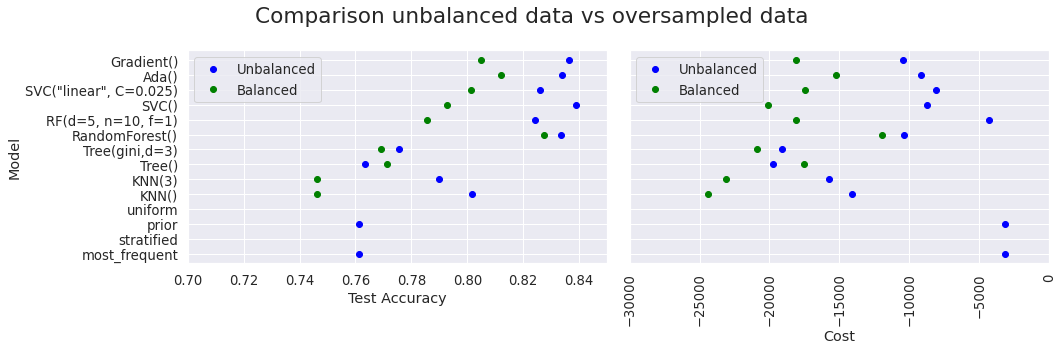

In [56]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
sns.set(font_scale=1.5)
fig.suptitle('Comparison unbalanced data vs oversampled data')
sns.set(font_scale=1.2)
_ = ax[0].plot(models_summary['test accuracy'],models_summary['model_name'],'o',linestyle='None',color='blue')
_ = ax[0].plot(models_summary_over['test accuracy'],models_summary_over['model_name'],'o',linestyle='None',color='green')
_ = ax[0].legend(['Unbalanced', 'Balanced'])
labels = short_names
_ = ax[0].set_yticklabels(labels, rotation=0)
_ = ax[0].set_xlim([0.7,0.85])
#_ = ax[0].set_title('Test Accuracy')
_ = ax[0].set_xlabel('Test Accuracy')
_ = ax[0].set_ylabel('Model')

_ = ax[1].plot(models_summary['cost'],models_summary['model_name'],'o',linestyle='None',color='blue')
_ = ax[1].plot(models_summary_over['cost'],models_summary_over['model_name'],'o',linestyle='None',color='green')
_ = ax[1].legend(['Unbalanced', 'Balanced'])
labels = short_names
_ = ax[1].set_yticklabels(labels, rotation=0)
_ = plt.xticks(rotation=90)
_ = ax[1].set_xlim([-30000, 0])
#ax[1].set_title('Cost')
_ = ax[1].set_xlabel('Cost')
#ax[1].set_ylabel('Cost')

plt.tight_layout()
plt.savefig("../figures/Naive_model_comparison.png") 


In [57]:
models_summary[['model_name','cost','test accuracy']].sort_values(by=['test accuracy'], ascending=False)

,model_name,cost,test accuracy
10,SVC(),-8743.0,0.838958
13,GradientBoostingClassifier(),-10480.0,0.836210
12,AdaBoostClassifier(),-9172.0,0.833919
8,RandomForestClassifier(),-10382.0,0.833461
11,"SVC(C=0.025, kernel='linear')",-8091.0,0.826130
9,"RandomForestClassifier(max_depth=5, max_featur...",-4276.0,0.824145
4,KNeighborsClassifier(),-14083.0,0.801848
5,KNeighborsClassifier(n_neighbors=3),-15766.0,0.790012
7,DecisionTreeClassifier(max_depth=3),-19133.0,0.775733
6,DecisionTreeClassifier(),-19718.0,0.763516


## Hyperparameters Tuning

Let's finetune Random Forest and Support Vector Classifiers as they are the top performers when considering both Accuracy and Cost.
- SVC - linear / RBF (best accuracy)

- Random Forest (lowest cost)

### GridSearchCV
We set up the code but it turns out to be too time consuming. We didn't complete this in favor of Bayesin Search Optimization 


In [60]:
# model_grid = [{'C' : np.logspace(-2, 5,num=8),
#                'kernel': ['linear','rbf'],
#                'gamma' :  np.logspace(-2, 3,num=6)},
#               {'n_estimators':np.arange(50,201,50),
#                'criterion':['gini', 'entropy'],
#                'max_depth':np.arange(1,11,2)}]             
# models = [SVC(), RandomForestClassifier()]    
# hyper_tuning = pd.DataFrame()
# for model, param_grid in tqdm(zip(models, model_grid)):
#     print("Training model : " + str(model))
#     print("Start Time : "+ str(datetime.now()))
#     grid_cv = GridSearchCV(model,param_grid, cv=3, refit=True)
#     start = timer()
#     grid_cv.fit(X_train_scaled,y_train)
#     end = timer()
#     test_score = grid_cv.score(X_test_scaled, y_test)
#     y_pred = grid_cv.predict(X_test_scaled)
#     cm = confusion_matrix(y_test, y_pred)
#     cost = my_cost_function(y_test, y_pred)
#     print(str(round(end - start,3)) + ' seconds elapsed.')
#     print("|----Best Score:" + str(grid_cv.best_score_))
#     print("|----Best Parameters: " + str(grid_cv.best_params_))
#     hyper_tuning = hyper_tuning.append({'Training model': model,
#                         'grid_cv object': grid_cv,
#                         'Time':round(end - start,3),
#                         'Test Score':test_score,
#                         'Cost':cost,
#                         'Best Score':grid_cv.best_score_,
#                         'Confusion Matrix':cm,
#                         'Best Parameters': grid_cv.best_params_}, ignore_index=True)

Results obtained on a very small subset of the parameters space for debugging puropses
```
Training model : SVC()
1075.062 seconds elapsed.
|----Best Score:0.7905578983083709
|----Best Parameters: {'C': 81, 'gamma': 'auto', 'kernel': 'rbf'}
Training model : RandomForestClassifier()
350.659 seconds elapsed.
|----Best Score:0.7915273132664437
|----Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 50}
```

### Bayesian Optiomization


In [109]:
# define search space 
params_list = [{'n_estimators': Integer(1, 1000, prior='linear'),
          'max_depth': Integer(1, 10, prior='linear'),
          'criterion': Categorical(['gini', 'entropy'])},
          {'C': Real(1e-2, 1e+5, prior='log-uniform'),
          'gamma': Real(1e-2, 1e+3, prior='log-uniform'),
          'kernel': Categorical(['rbf'])},
          {'C': Real(1e-2, 1e+5, prior='log-uniform'),
          'gamma': Real(1e-2, 1e+3, prior='log-uniform'),
          'kernel': Categorical(['linear'])}]

estimator_list = [RandomForestClassifier(),SVC(), SVC()]

# define the search
for model, param_grid in tqdm(zip(estimator_list,params_list)):
    print("Searching best parameters for "+ str(model))
    print("Start Time : "+ str(datetime.now()))
    search = BayesSearchCV(estimator=model,
                         search_spaces=param_grid,
                         n_jobs=-1,
                         n_iter=10,
                         n_points=2,
                         random_state=0,
                         cv=3,
                         verbose=100,
                         refit=True,
                         return_train_score = True)
    # perform bayesian optimization
    print("Start Time : "+ str(datetime.now()))
    search.fit(X_train_scaled, y_train)
    print("End Time : "+ str(datetime.now()))
    pkl_filename = "pickle_bayes_search_model_"+ str(datetime.now())  +".pkl"
    pkl_path = "../data/"+pkl_filename
    print(type(search))
    with open(pkl_path, 'wb') as file:
        pickle.dump(search, file)
    print("|----Best Score:" + str(search.best_score_))
    print("|----Best Parameters: " + str(search.best_params_))

Searching best parameters for RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Start Time : 2020-10-18 17:48:49.184060
Start Time : 2020-10-18 17:48:49.184185
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   17.6s remaining:   35.2s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   18.2s rem

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   11.4s remaining:   22.8s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   11.5s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   18.9s remaining:    9.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.6s finished
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:   14.9s remaining:   29.7s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   16.0s remaining:   16.0s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   18.6s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=-1)]:

Results

```
RandomForestClassifier()
0.7911880180311183
OrderedDict([('criterion', 'entropy'), ('max_depth', 8), ('n_estimators', 679)])

SVC() - Rbf
0.7880374194173816
OrderedDict([('C', 156.81728269807493), ('gamma', 0.20540985697592978), ('kernel', 'rbf')])

SVC() - Linear
0.7835781106102467
OrderedDict([('C', 156.81728269807493), ('gamma', 0.20540985697592978), ('kernel', 'linear')])



```

```
Test Score = 0.8411728772144166
CV Score = 0.7903155445688527
OrderedDict([('C', 11428.693628355693), ('degree', 8), ('gamma', 0.13609648966949792), ('kernel', 'poly')])

```

# Model Choice

pickle_bayes_search_model_2020-10-18 17:52:13.493398.pkl
OrderedDict([('criterion', 'entropy'), ('max_depth', 8), ('n_estimators', 679)])
Test Score :0.8333842394624312
Cost :-8830
pickle_bayes_search_model_2020-10-18 18:01:04.933374.pkl
OrderedDict([('C', 156.81728269807493), ('gamma', 0.20540985697592978), ('kernel', 'rbf')])
Test Score :0.8388057422113623
Cost :-8484
pickle_bayes_search_model_2020-10-18 18:03:24.166276.pkl
OrderedDict([('C', 156.81728269807493), ('gamma', 0.20540985697592978), ('kernel', 'linear')])
Test Score :0.8339951130116066
Cost :-8654


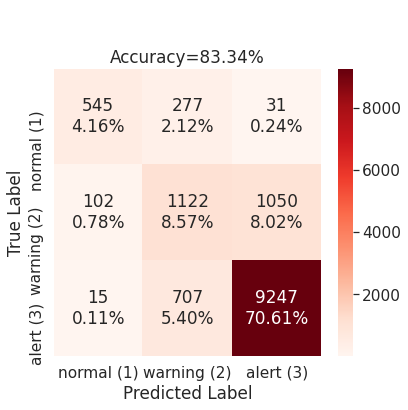

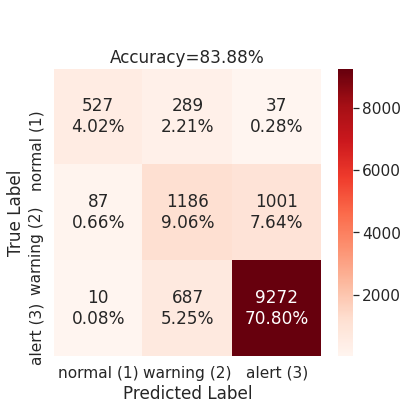

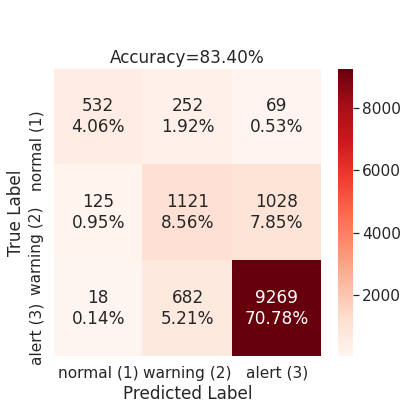

In [110]:
pkl_list = ["pickle_bayes_search_model_2020-10-18 17:52:13.493398.pkl",
           "pickle_bayes_search_model_2020-10-18 18:01:04.933374.pkl",
           "pickle_bayes_search_model_2020-10-18 18:03:24.166276.pkl"]
            
pkl_path = "../data/"+pkl_filename

for pkl in pkl_list :
    # Load Model
    pkl_path = "../data/" + pkl
    loaded_model = pickle.load(open(pkl_path, 'rb'))
    
    # calculate
    test_score = loaded_model.score(X_test_scaled, y_test)
    y_pred = loaded_model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    cost = my_cost_function(y_test, y_pred)
    
    # Print Summary
    #print(loaded_model)
    print(pkl)
    print(loaded_model.best_params_)
    print('Test Score :' + str(test_score))
    print('Cost :' + str(cost))
    #Plot Confusion Matrix
    _ = plot_multiclass_confusion_matrix(y_test, y_pred,['normal (1)','warning (2)','alert (3)'])
    plt.tight_layout()
    plt.savefig("../figures/"+pkl+'.png') 
    
   
    

The Support Vector Classifier with rbf kernel has both a higher accuracy and a lower cost due to misclassification

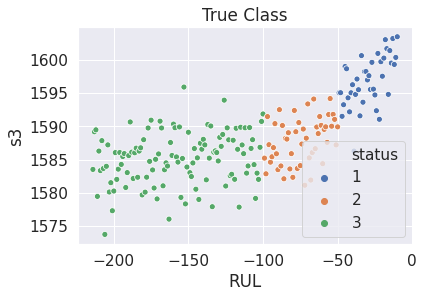

In [111]:
import random
#let's see it in action
# pick one engine trace from the test dataset
test_df = pd.read_csv('../data/test_op_regime2_FD001.csv')

# random_unit = random.choice(test_df['unit_number'].unique())
# print('Unit number : '+ str(random_unit)) 
random_unit = 76 #76 is a good example

test_df = test_df[test_df['unit_number']==random_unit]

#setting an arbitary boundary at 50 and 100 cycles for the binning\
first_boundary = -100
second_boundary = -50
test_df['status'] = pd.cut(test_df['RUL'],[-np.inf,first_boundary,second_boundary,0],labels=[3,2,1])

_ = sns.scatterplot('RUL','s3',data = test_df, hue='status')
_ = plt.title('True Class')
plt.savefig('../figures/SIMULATION_true_class.png')

In [112]:
cols_to_drop = ['dataset','unit_number', 
        'op_setting_1', 'op_setting_2', 'op_setting_3',
        's1', 's5', 's6', 's10', 's16', 's18', 's19',
        'op_regime','RUL']
predictor_col = ['status']

X_test = test_df.drop(cols_to_drop + predictor_col, axis=1).to_numpy()
X_test_scaled=scaler.transform(X_test)

best_model = pickle.load(open("../data/pickle_bayes_search_model_2020-10-18 18:01:04.933374.pkl", 'rb'))
y_pred = best_model.predict(X_test_scaled)
test_df['pred_status']=y_pred

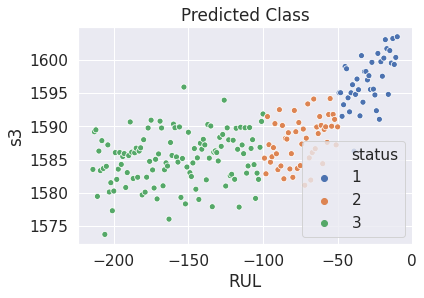

In [113]:
_ = sns.scatterplot('RUL','s3',data = test_df, hue='status')
_ = plt.title('Predicted Class')
plt.savefig('../figures/SIMULATION_predicted_class.png')

In [114]:
test_df['correct'] = test_df['pred_status'] == test_df['status']

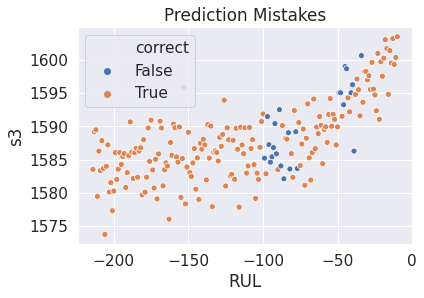

In [115]:
_ = sns.scatterplot('RUL','s3',data = test_df, hue='correct')
_ = plt.title('Prediction Mistakes')
plt.savefig('../figures/SIMULATION_classification_error.png')